In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

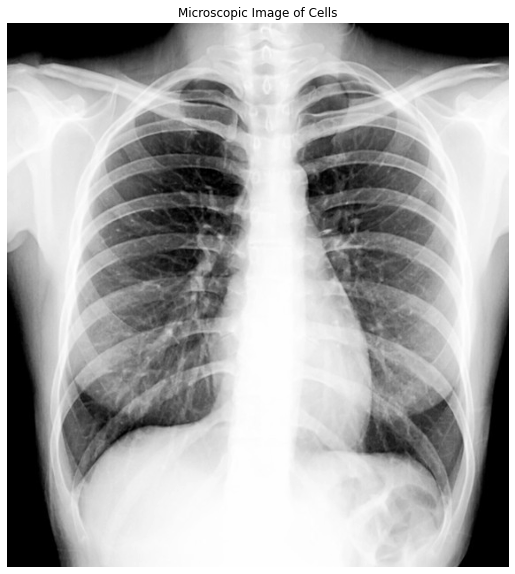

In [5]:
# URL of image of Henrietta Lacks cells
url = 'https://domf5oio6qrcr.cloudfront.net/medialibrary/6839/ddca3f92-4b8e-4672-bb6b-f3594ad4e304.jpg'

# Load the image from the URL
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Convert the image to grayscale
image = image.convert('L')
image_np = np.array(image)

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(image_np, cmap='gray')
plt.title('Microscopic Image of Cells')
plt.axis('off')
plt.show()

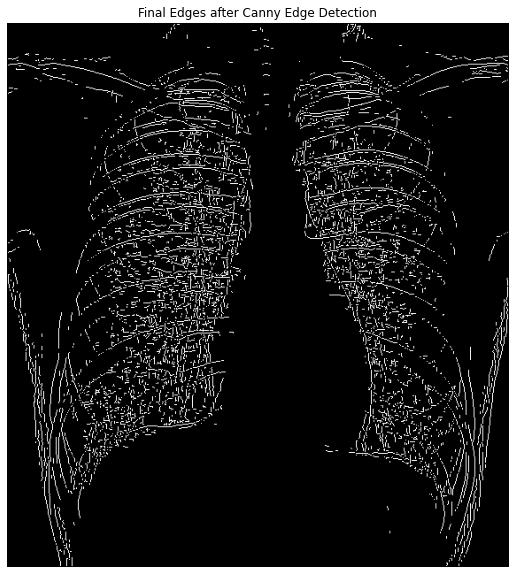

In [6]:
# Function definitions for edge detection steps
def compute_gradients(image):
    Gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(Gx**2 + Gy**2)
    direction = np.arctan2(Gy, Gx)
    return magnitude, direction

def non_maximum_suppression(magnitude, direction):
    rows, cols = magnitude.shape
    suppressed = np.zeros((rows, cols), dtype=np.float32)
    angle = direction * 180.0 / np.pi
    angle[angle < 0] += 180

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            q = 255
            r = 255
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = magnitude[i, j+1]
                r = magnitude[i, j-1]
            elif 22.5 <= angle[i, j] < 67.5:
                q = magnitude[i+1, j-1]
                r = magnitude[i-1, j+1]
            elif 67.5 <= angle[i, j] < 112.5:
                q = magnitude[i+1, j]
                r = magnitude[i-1, j]
            elif 112.5 <= angle[i, j] < 157.5:
                q = magnitude[i-1, j-1]
                r = magnitude[i+1, j+1]

            if (magnitude[i, j] >= q) and (magnitude[i, j] >= r):
                suppressed[i, j] = magnitude[i, j]
            else:
                suppressed[i, j] = 0

    return suppressed

def double_threshold(image, low_thresh, high_thresh):
    strong = np.zeros(image.shape, dtype=np.uint8)
    weak = np.zeros(image.shape, dtype=np.uint8)
    strong[image >= high_thresh] = 255
    weak[(image >= low_thresh) & (image < high_thresh)] = 255
    return strong, weak

def edge_tracking_by_hysteresis(strong, weak):
    final_edges = np.copy(strong)
    rows, cols = strong.shape
    for r in range(1, rows-1):
        for c in range(1, cols-1):
            if weak[r, c] == 255:
                if (strong[r-1:r+2, c-1:c+2] == 255).any():
                    final_edges[r, c] = 255
                else:
                    final_edges[r, c] = 0
    return final_edges

# Compute gradient magnitudes and directions
magnitude, direction = compute_gradients(image_np)

# Apply Non-Maximum Suppression
suppressed = non_maximum_suppression(magnitude, direction)

# Double Thresholding
low_threshold = 30
high_threshold = 80
strong_edges, weak_edges = double_threshold(suppressed, low_threshold, high_threshold)

# Edge Tracking by Hysteresis
final_edges = edge_tracking_by_hysteresis(strong_edges, weak_edges)

# Display final edges
plt.figure(figsize=(10, 10))
plt.imshow(final_edges, cmap='gray')
plt.title('Final Edges after Canny Edge Detection')
plt.axis('off')
plt.show()